## LDA/QDA

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_X_y
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, make_scorer, precision_recall_curve, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
#read df
df = pd.read_csv('../final_merged_data.csv')

# Convert sodium to numeric
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')

# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing values per column:
cholesterol       4
sodium            1
carbohydrates     1
dietary_fiber    20
sugar             8
protein           1
price            22
dtype: int64


In [3]:
#drop na
df = df.dropna()

print("\nBestseller distribution:")
print(df['bestseller'].value_counts())


Bestseller distribution:
bestseller
0    662
1    260
Name: count, dtype: int64


In [55]:
# numeric features 
numeric_features = ['calories', 'total_fat', 'saturated_fat', 'trans_fat', 
                   'cholesterol', 'sodium', 'carbohydrates', 'dietary_fiber', 
                   'sugar', 'protein', 'price', 'new_item_2022']

# encode categorical features 
categorical_features = ['food_category']
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# features and target
X = pd.concat([df[numeric_features], df_encoded], axis=1)
y = df['bestseller']

In [95]:
def tune_discriminant_models(X, y, test_size=0.2, random_state=5300):
    """
    Tune and compare both LDA and QDA models for classification.
    
    Parameters:
    X : feature matrix (DataFrame)
    y : target vector
    test_size : proportion of data to use for testing
    random_state : random seed for reproducibility
    
    Returns:
    results : dictionary with model results and performance metrics
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    # Parameter grid for QDA
    qda_param_grid = {
        'qda__reg_param': np.linspace(0, 1, 11),
        'qda__store_covariance': [True, False],
        'smote__sampling_strategy': [0.5, 0.6, 0.7],
        'smote__k_neighbors': [3, 5, 7]
    }
    
    # Parameter grid for LDA 
    lda_param_grid = {
        'lda__solver': ['svd', 'lsqr', 'eigen'],
        'smote__sampling_strategy': [0.5, 0.6, 0.7],
        'smote__k_neighbors': [3, 5, 7]
    }
    
    # Add shrinkage only for appropriate solvers
    lda_param_grid_with_shrinkage = {
        'lda__solver': ['lsqr', 'eigen'],
        'lda__shrinkage': ['auto'] + list(np.linspace(0.1, 0.9, 5)),
        'lda__store_covariance': [True, False],
        'smote__sampling_strategy': [0.5, 0.6, 0.7],
        'smote__k_neighbors': [3, 5, 7]
    }
    
    # Pipeline with StandardScaler, SMOTE, and QDA
    qda_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=random_state)),
        ('qda', QuadraticDiscriminantAnalysis())
    ])
    
    # Pipeline with StandardScaler, SMOTE, and LDA
    lda_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=random_state)),
        ('lda', LinearDiscriminantAnalysis())
    ])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Custom F1 scorer for the positive class
    f1_scorer = make_scorer(
        f1_score, 
        pos_label=1, 
        average='binary'
    )
    
    # Grid search for QDA
    print("Tuning QDA model...")
    qda_grid_search = GridSearchCV(qda_pipeline, param_grid=qda_param_grid, 
                                cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=1)
    qda_grid_search.fit(X_train, y_train)
    qda_best_model = qda_grid_search.best_estimator_
    qda_best_params = qda_grid_search.best_params_
    qda_best_score = qda_grid_search.best_score_
    
    # Grid search for LDA - First without shrinkage
    print("\nTuning LDA model (without shrinkage)...")
    lda_grid_search = GridSearchCV(lda_pipeline, param_grid=lda_param_grid, 
                                cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=1)
    lda_grid_search.fit(X_train, y_train)
    lda_best_model_no_shrinkage = lda_grid_search.best_estimator_
    lda_best_params_no_shrinkage = lda_grid_search.best_params_
    lda_best_score_no_shrinkage = lda_grid_search.best_score_
    
    # Grid search for LDA - With shrinkage
    print("\nTuning LDA model (with shrinkage)...")
    lda_shrinkage_grid_search = GridSearchCV(lda_pipeline, param_grid=lda_param_grid_with_shrinkage, 
                                          cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=1)
    lda_shrinkage_grid_search.fit(X_train, y_train)
    lda_best_model_with_shrinkage = lda_shrinkage_grid_search.best_estimator_
    lda_best_params_with_shrinkage = lda_shrinkage_grid_search.best_params_
    lda_best_score_with_shrinkage = lda_shrinkage_grid_search.best_score_
    
    # Choose the better LDA model
    if lda_best_score_with_shrinkage > lda_best_score_no_shrinkage:
        lda_best_model = lda_best_model_with_shrinkage
        lda_best_params = lda_best_params_with_shrinkage
        lda_best_score = lda_best_score_with_shrinkage
        print("\nLDA model with shrinkage performed better.")
    else:
        lda_best_model = lda_best_model_no_shrinkage
        lda_best_params = lda_best_params_no_shrinkage
        lda_best_score = lda_best_score_no_shrinkage
        print("\nLDA model without shrinkage performed better.")
    
    # Function to evaluate model and get metrics
    def evaluate_model(model, model_name, params, cv_score):
        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate performance metrics
        model_results = {
            'best_params': params,
            'best_cv_score': cv_score,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_f1_score': f1_score(y_test, y_pred, pos_label=1),
            'test_auc': roc_auc_score(y_test, y_proba),
            'classification_report': classification_report(y_test, y_pred),
            'best_model': model
        }
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Bestseller', 'Bestseller'],
                   yticklabels=['Not Bestseller', 'Bestseller'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name} with SMOTE')
        plt.tight_layout()
        plt.show()
        
        # Detailed classification metrics
        print(f"\n{model_name} Classification Metrics:")
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity', 'F1 Score', 'AUC'],
            'Value': [
                f"{model_results['test_accuracy']:.4f}",
                f"{precision:.4f}",
                f"{recall:.4f}",
                f"{specificity:.4f}",
                f"{f1:.4f}",
                f"{model_results['test_auc']:.4f}"
            ]
        })
        print(metrics_df.to_string(index=False))
        
        # Threshold optimization
        thresholds = np.linspace(0.1, 0.9, 9)
        f1_scores = []
        
        for threshold in thresholds:
            y_pred_threshold = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_test, y_pred_threshold, pos_label=1)
            f1_scores.append(f1)
        
        best_threshold_idx = np.argmax(f1_scores)
        model_results['optimal_threshold'] = thresholds[best_threshold_idx]
        model_results['optimal_f1_score'] = f1_scores[best_threshold_idx]
        
        # Predictions with optimal threshold
        y_pred_optimal = (y_proba >= model_results['optimal_threshold']).astype(int)
        model_results['optimal_classification_report'] = classification_report(y_test, y_pred_optimal)
    
        # Confusion matrix optimal
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Bestseller', 'Bestseller'],
                   yticklabels=['Not Bestseller', 'Bestseller'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name} with Optimal Threshold ({model_results["optimal_threshold"]:.2f})')
        plt.tight_layout()
        plt.show()
        
        # Detailed classification metrics with optimal threshold
        print(f"\n{model_name} Classification Metrics with Optimal Threshold ({model_results['optimal_threshold']:.2f}):")
        tn, fp, fn, tp = cm_optimal.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity', 'F1 Score'],
            'Value': [
                f"{accuracy_score(y_test, y_pred_optimal):.4f}",
                f"{precision:.4f}",
                f"{recall:.4f}",
                f"{specificity:.4f}",
                f"{f1:.4f}"
            ]
        })
        print(metrics_df.to_string(index=False))
        
        # Plot threshold optimization
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, f1_scores, 'o-', linewidth=2)
        plt.axvline(x=model_results['optimal_threshold'], color='r', linestyle='--')
        plt.text(model_results['optimal_threshold'] + 0.02, min(f1_scores) + 0.02, 
                f'Optimal threshold: {model_results["optimal_threshold"]:.2f}')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title(f'F1 Score vs. Threshold for {model_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        return model_resultsno_shrinkage
        lda_best_score = lda_best_score_no_shrinkage
        print("\nLDA model without shrinkage performed better.")
    
    # Function to evaluate model and get metrics
    def evaluate_model(model, model_name, params, cv_score):
        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate performance metrics
        model_results = {
            'best_params': params,
            'best_cv_score': cv_score,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_f1_score': f1_score(y_test, y_pred, pos_label=1),
            'test_auc': roc_auc_score(y_test, y_proba),
            'classification_report': classification_report(y_test, y_pred),
            'best_model': model
        }
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Bestseller', 'Bestseller'],
                   yticklabels=['Not Bestseller', 'Bestseller'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name} with SMOTE')
        plt.tight_layout()
        plt.show()
        
        # Threshold optimization
        thresholds = np.linspace(0.1, 0.9, 9)
        f1_scores = []
        
        for threshold in thresholds:
            y_pred_threshold = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_test, y_pred_threshold, pos_label=1)
            f1_scores.append(f1)
        
        best_threshold_idx = np.argmax(f1_scores)
        model_results['optimal_threshold'] = thresholds[best_threshold_idx]
        model_results['optimal_f1_score'] = f1_scores[best_threshold_idx]
        
        # Predictions with optimal threshold
        y_pred_optimal = (y_proba >= model_results['optimal_threshold']).astype(int)
        model_results['optimal_classification_report'] = classification_report(y_test, y_pred_optimal)
    
        # Confusion matrix optimal
        cm = confusion_matrix(y_test, y_pred_optimal)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Bestseller', 'Bestseller'],
                   yticklabels=['Not Bestseller', 'Bestseller'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name} with SMOTE with Optimal Threshold')
        plt.tight_layout()
        plt.show()
        
        return model_results
    
    # Evaluate both models
    qda_results = evaluate_model(qda_best_model, "QDA", qda_best_params, qda_best_score)
    lda_results = evaluate_model(lda_best_model, "LDA", lda_best_params, lda_best_score)
    
    # Print classification reports
    print("\nQDA Classification Report:")
    print(qda_results['classification_report'])
    
    print("\nQDA Classification Report with Optimal Threshold:")
    print(qda_results['optimal_classification_report'])
    
    print("\nLDA Classification Report:")
    print(lda_results['classification_report'])
    
    print("\nLDA Classification Report with Optimal Threshold:")
    print(lda_results['optimal_classification_report'])
    
    # Compare models
    print("\nModel Comparison:")
    comparison = pd.DataFrame({
        'Metric': ['Best CV Score', 'Test Accuracy', 'Test F1 Score', 'Test AUC', 'Optimal F1 Score'],
        'QDA': [qda_results['best_cv_score'], qda_results['test_accuracy'], 
                qda_results['test_f1_score'], qda_results['test_auc'], qda_results['optimal_f1_score']],
        'LDA': [lda_results['best_cv_score'], lda_results['test_accuracy'], 
                lda_results['test_f1_score'], lda_results['test_auc'], lda_results['optimal_f1_score']]
    })
    print(comparison)
    
    # ROC curves for comparison
    plt.figure(figsize=(10, 8))
    
    # QDA ROC curve
    qda_y_proba = qda_best_model.predict_proba(X_test)[:, 1]
    qda_fpr, qda_tpr, _ = roc_curve(y_test, qda_y_proba)
    qda_auc = auc(qda_fpr, qda_tpr)
    plt.plot(qda_fpr, qda_tpr, lw=2, label=f'QDA (AUC = {qda_auc:.3f})')
    
    # LDA ROC curve
    lda_y_proba = lda_best_model.predict_proba(X_test)[:, 1]
    lda_fpr, lda_tpr, _ = roc_curve(y_test, lda_y_proba)
    lda_auc = auc(lda_fpr, lda_tpr)
    plt.plot(lda_fpr, lda_tpr, lw=2, label=f'LDA (AUC = {lda_auc:.3f})')
    
    # Reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: QDA vs LDA')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Determine which model performed better based on F1 score
    better_model = "QDA" if qda_results['test_f1_score'] >= lda_results['test_f1_score'] else "LDA"
    
    # Return both model results in a dictionary
    results = {
        'qda_results': qda_results,
        'lda_results': lda_results,
        'better_model': better_model,
        'comparison': comparison
    }
    
    return results

def extract_feature_importance(X, y, model_results, feature_names):
    """
    Extract feature importance from LDA and QDA models
    
    Parameters:
    X : feature matrix (DataFrame)
    y : target vector
    model_results : dictionary containing model results
    feature_names : list of feature names
    
    Returns:
    importance_df : DataFrame with feature importance scores
    """
    results = {}
    
    for model_name in ['qda', 'lda']:
        model = model_results[f'{model_name}_results']['best_model']
        
        # Extract discriminant analysis model from pipeline
        discriminant_model = model.named_steps[model_name]
        
        # Get scaled features
        X_scaled = model.named_steps['scaler'].transform(X)
        
        # Get class means
        class_0_mask = (y == 0)
        class_1_mask = (y == 1)
        
        class_0_means = np.mean(X_scaled[class_0_mask], axis=0)
        class_1_means = np.mean(X_scaled[class_1_mask], axis=0)
        mean_diff = np.abs(class_1_means - class_0_means)
        
        # Scale the differences to sum to 1
        mean_diff_normalized = mean_diff / np.sum(mean_diff)
        
        # For LDA, we can also get coefficients of the linear discriminant
        if model_name == 'lda' and hasattr(discriminant_model, 'coef_'):
            coef = np.abs(discriminant_model.coef_[0])
            coef_normalized = coef / np.sum(coef)
        else:
            coef_normalized = np.zeros_like(mean_diff_normalized)
        
        # Calculate permutation importance
        from sklearn.inspection import permutation_importance
        
        # Split data for permutation importance calculation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        
        # Calculate permutation importance
        perm_importance = permutation_importance(
            model, X_test, y_test, 
            n_repeats=10, random_state=10, 
            scoring='f1')
        
        perm_importance_mean = perm_importance.importances_mean
        
        # Handle case where all importance values are zero
        if np.sum(perm_importance_mean) == 0:
            perm_importance_norm = np.ones_like(perm_importance_mean) / len(perm_importance_mean)
        else:
            # Normalize to sum to 1
            perm_importance_norm = perm_importance_mean / np.sum(perm_importance_mean)
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean_Diff_Importance': mean_diff_normalized,
            'Permutation_Importance': perm_importance_norm
        })
        
        # Add LDA coefficients if available
        if model_name == 'lda' and hasattr(discriminant_model, 'coef_'):
            importance_df['LDA_Coefficient_Importance'] = coef_normalized
            importance_df['Average_Importance'] = importance_df[
                ['Mean_Diff_Importance', 'Permutation_Importance', 'LDA_Coefficient_Importance']
            ].mean(axis=1)
        else:
            importance_df['Average_Importance'] = importance_df[
                ['Mean_Diff_Importance', 'Permutation_Importance']
            ].mean(axis=1)
        
        # Sort by average importance
        importance_df = importance_df.sort_values('Average_Importance', ascending=False)
        
        # Add to results
        results[model_name] = importance_df
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Average_Importance', y='Feature', data=importance_df)
        plt.title(f'Average Feature Importance from {model_name.upper()}')
        plt.tight_layout()
        plt.show()
        
        # Display feature importance table
        print(f"\n{model_name.upper()} Feature Importance Ranking:")
        display_df = importance_df[['Feature', 'Average_Importance']].copy()
        display_df['Average_Importance'] = display_df['Average_Importance'].apply(lambda x: f"{x:.4f}")
        print(display_df.to_string(index=False))
        
        # Visualize the relationship between top features and class
        top_features = importance_df.nlargest(3, 'Average_Importance')['Feature'].tolist()
        
        plt.figure(figsize=(15, 5))
        for i, feature in enumerate(top_features):
            plt.subplot(1, 3, i+1)
            # Create a copy of data just for plotting
            plot_data = pd.DataFrame({
                'bestseller': y,
                feature: X[feature]  # Use pandas indexing
            })
            sns.boxplot(x='bestseller', y=feature, data=plot_data)
            plt.title(f'Bestseller vs {feature}')
        plt.tight_layout()
        plt.show()
    
    # Compare feature importance between models
    top_features = pd.DataFrame({
        'QDA_Top_Features': results['qda'].nlargest(5, 'Average_Importance')['Feature'].tolist(),
        'LDA_Top_Features': results['lda'].nlargest(5, 'Average_Importance')['Feature'].tolist()
    })
    
    print("\nTop 5 Features by Model:")
    print(top_features)
    
    # Return both importance DataFrames
    return results

Tuning QDA model...
Fitting 5 folds for each of 198 candidates, totalling 990 fits


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/pyth


Tuning LDA model (without shrinkage)...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/pyth


Tuning LDA model (with shrinkage)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/dsan5400/lib/pyth


LDA model with shrinkage performed better.


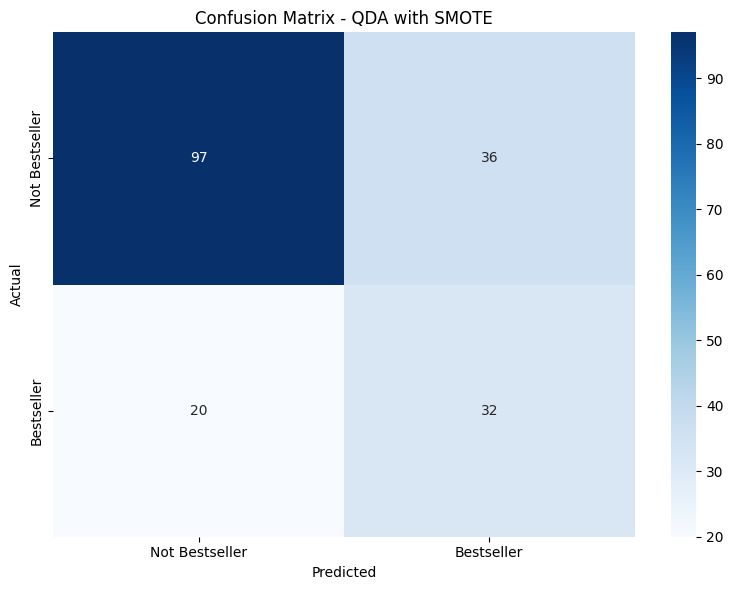

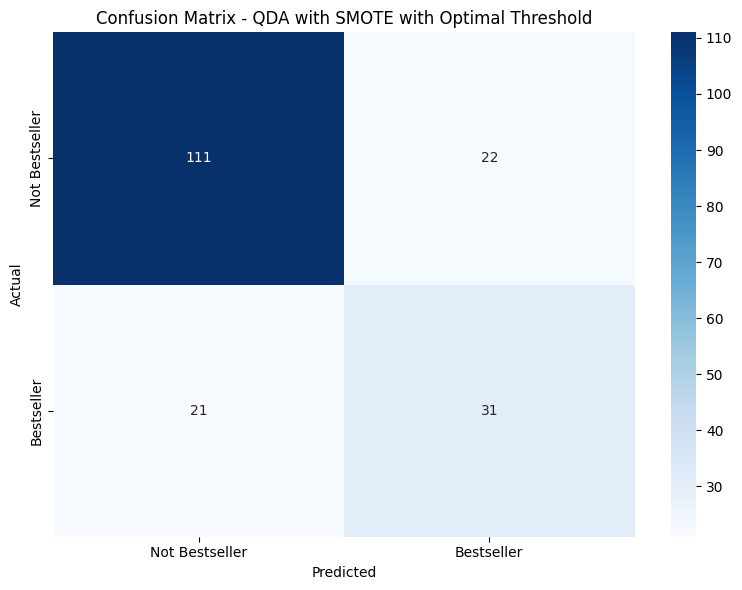

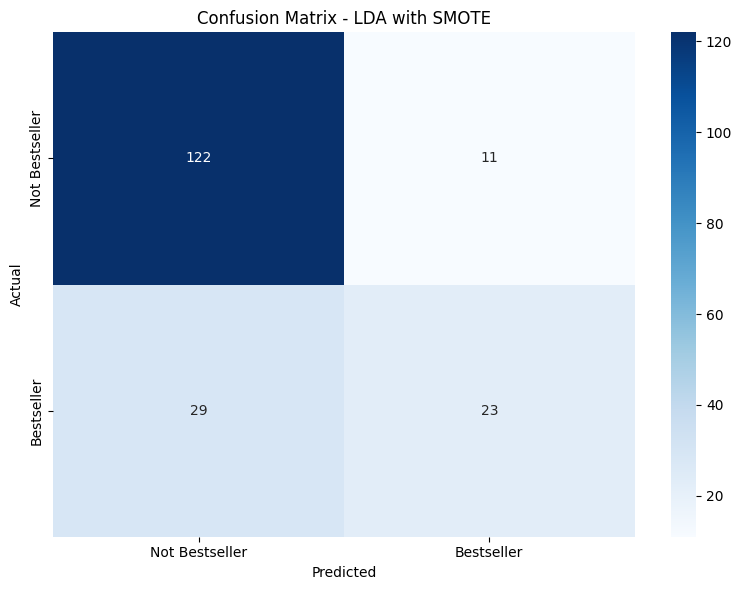

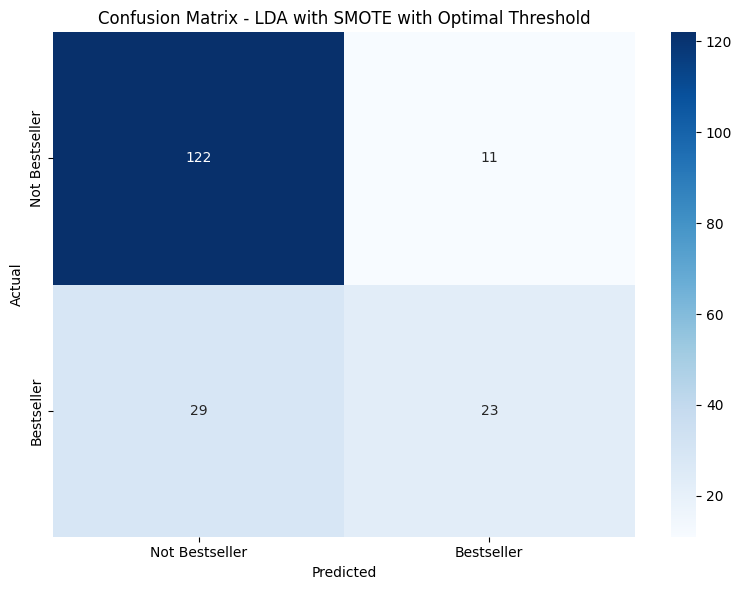


QDA Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       133
           1       0.47      0.62      0.53        52

    accuracy                           0.70       185
   macro avg       0.65      0.67      0.65       185
weighted avg       0.73      0.70      0.71       185


QDA Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       133
           1       0.58      0.60      0.59        52

    accuracy                           0.77       185
   macro avg       0.71      0.72      0.71       185
weighted avg       0.77      0.77      0.77       185


LDA Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       133
           1       0.68      0.44      0.53        52

    accuracy                           0.78       185
   macro avg       0.

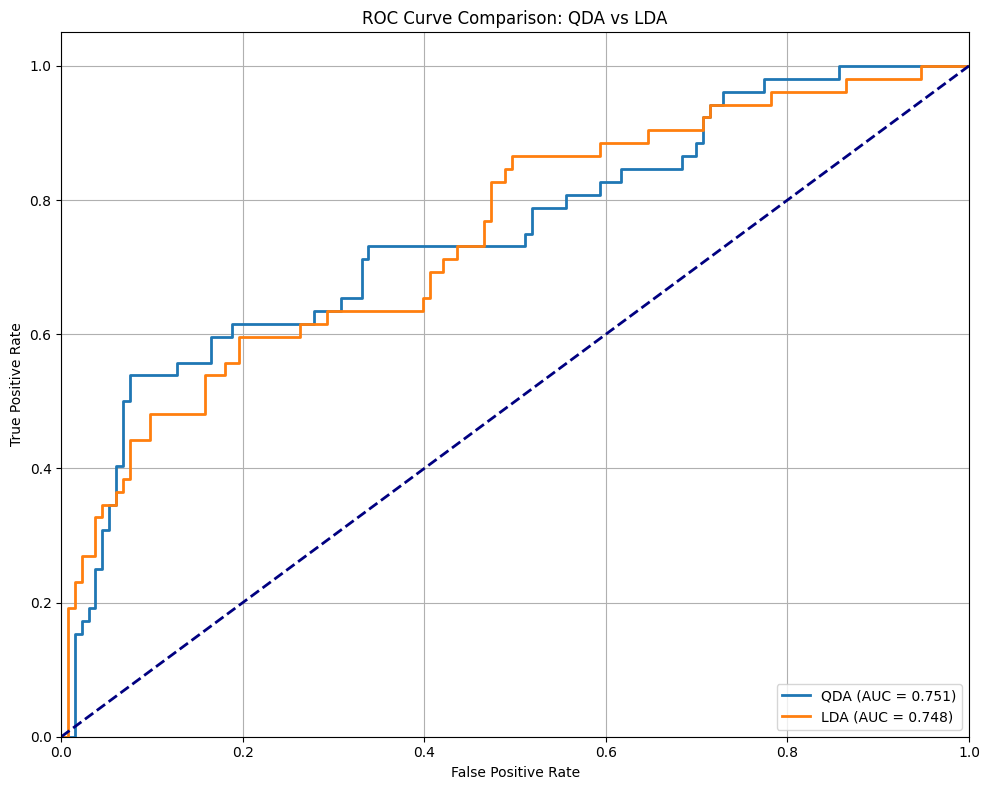

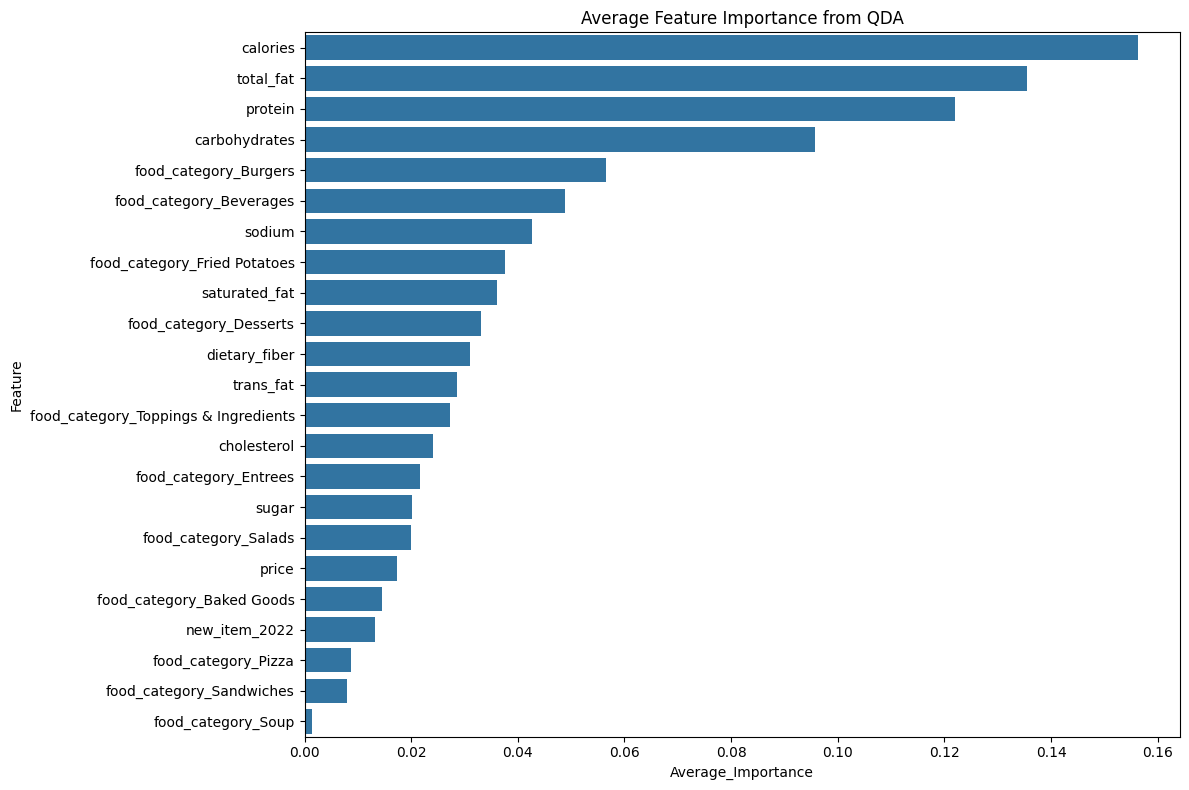


QDA Feature Importance Ranking:
                             Feature Average_Importance
                            calories             0.1563
                           total_fat             0.1355
                             protein             0.1219
                       carbohydrates             0.0958
               food_category_Burgers             0.0566
             food_category_Beverages             0.0489
                              sodium             0.0427
        food_category_Fried Potatoes             0.0377
                       saturated_fat             0.0360
              food_category_Desserts             0.0332
                       dietary_fiber             0.0310
                           trans_fat             0.0286
food_category_Toppings & Ingredients             0.0274
                         cholesterol             0.0240
               food_category_Entrees             0.0216
                               sugar             0.0201
               

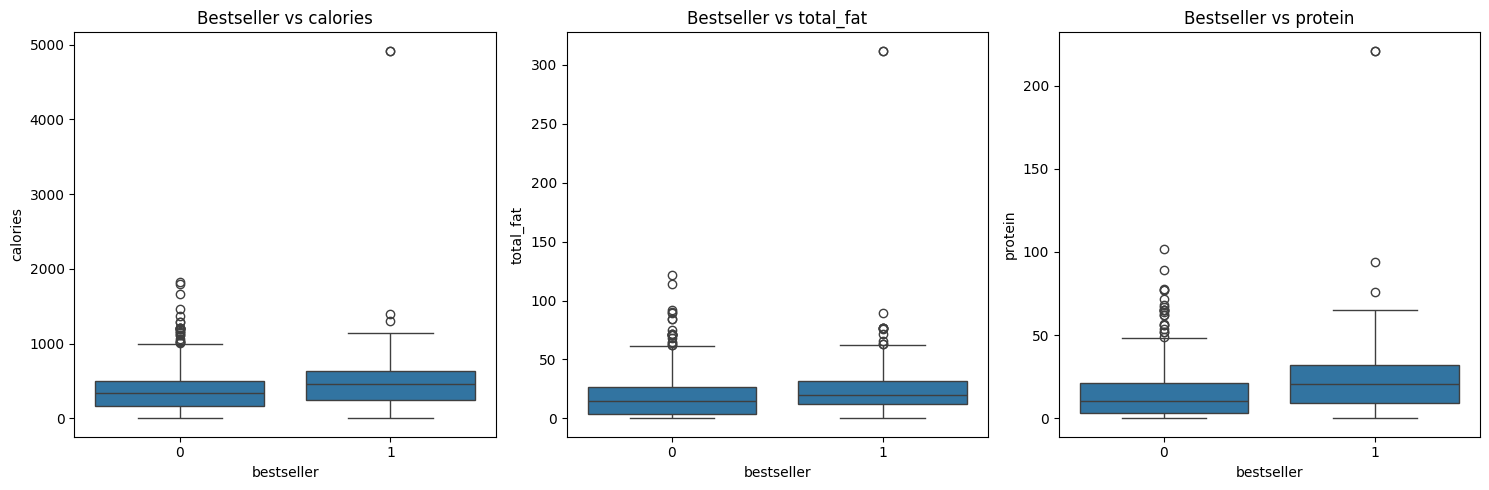

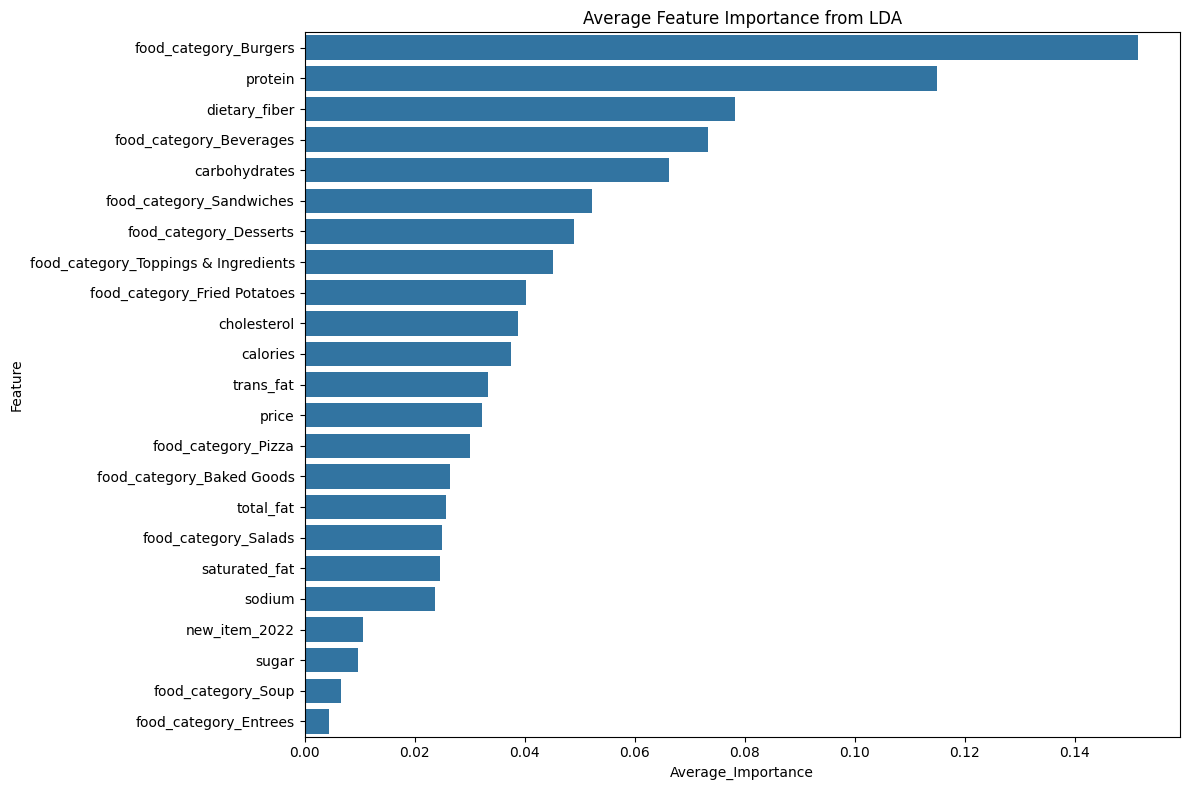


LDA Feature Importance Ranking:
                             Feature Average_Importance
               food_category_Burgers             0.1516
                             protein             0.1150
                       dietary_fiber             0.0783
             food_category_Beverages             0.0734
                       carbohydrates             0.0663
            food_category_Sandwiches             0.0523
              food_category_Desserts             0.0490
food_category_Toppings & Ingredients             0.0451
        food_category_Fried Potatoes             0.0402
                         cholesterol             0.0388
                            calories             0.0375
                           trans_fat             0.0334
                               price             0.0322
                 food_category_Pizza             0.0300
           food_category_Baked Goods             0.0264
                           total_fat             0.0258
               

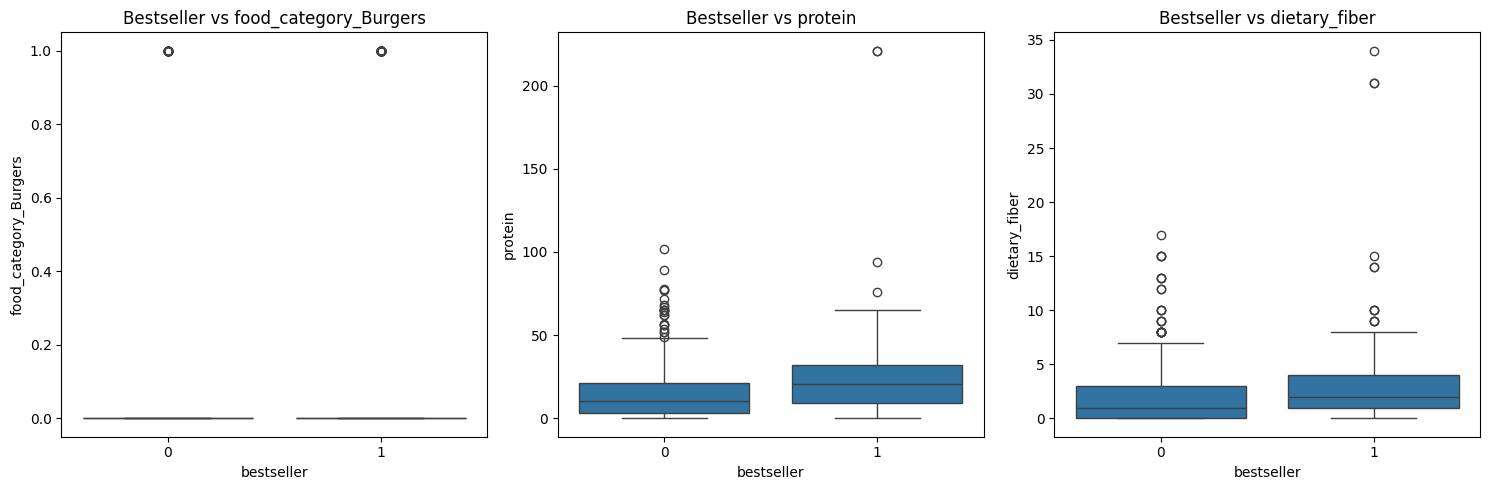


Top 5 Features by Model:
        QDA_Top_Features         LDA_Top_Features
0               calories    food_category_Burgers
1              total_fat                  protein
2                protein            dietary_fiber
3          carbohydrates  food_category_Beverages
4  food_category_Burgers            carbohydrates

Feature Importance for the Better Model (LDA):
                                 Feature  Mean_Diff_Importance  \
14                 food_category_Burgers              0.104071   
9                                protein              0.091696   
7                          dietary_fiber              0.061530   
13               food_category_Beverages              0.076434   
6                          carbohydrates              0.034325   
20              food_category_Sandwiches              0.013055   
15                food_category_Desserts              0.048446   
22  food_category_Toppings & Ingredients              0.045253   
17          food_category_Fried 

In [98]:
# Run the model comparison
model_results = tune_discriminant_models(X, y)

# Extract feature importance
feature_names = X.columns.tolist()
importance_results = extract_feature_importance(X, y, model_results, feature_names)

# Get the better model's importance
better_model = model_results['better_model'].lower()
print(f"\nFeature Importance for the Better Model ({better_model.upper()}):")
print(importance_results[better_model])